Net(
  (fc1): Linear(in_features=2, out_features=6, bias=True)
  (fc2): Linear(in_features=6, out_features=6, bias=True)
  (fc3): Linear(in_features=6, out_features=2, bias=True)
  (reluAct): ReLU()
  (tanAct): Tanh()
)
Fold 1/10
Fold [1/10], Train loss: 0.6931, Val loss: 0.6944
Fold 2/10
Fold [2/10], Train loss: 0.6929, Val loss: 0.6980
Fold 3/10
Fold [3/10], Train loss: 0.6931, Val loss: 0.6944
Fold 4/10
Fold [4/10], Train loss: 0.6926, Val loss: 0.7041
Fold 5/10
Fold [5/10], Train loss: 0.6931, Val loss: 0.6935
Fold 6/10
Fold [6/10], Train loss: 0.6918, Val loss: 0.7189
Fold 7/10
Fold [7/10], Train loss: 0.6927, Val loss: 0.7011
Fold 8/10
Fold [8/10], Train loss: 0.6931, Val loss: 0.6935
Fold 9/10
Fold [9/10], Train loss: 0.6931, Val loss: 0.6935
Fold 10/10
Fold [10/10], Train loss: 0.6931, Val loss: 0.6935
Average train loss: 0.6929, Average val loss: 0.6985


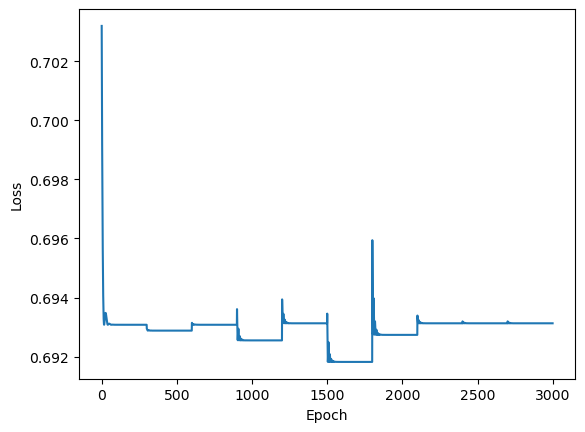

Train accuracy: 50.29%
Test accuracy: 47.37%


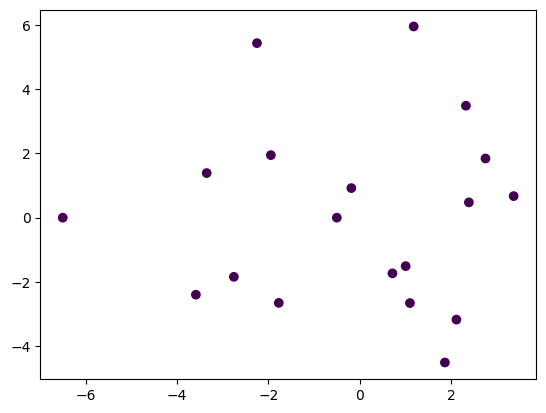

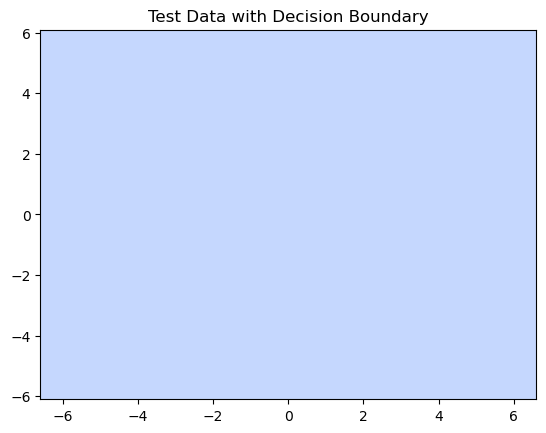

In [238]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

# Load the dataset
data = pd.read_csv('datasets/spiralsdataset.csv', header=None, names=['x1', 'x2', 'y'])
# Split the dataset into features and labels
X = data[['x1', 'x2']].to_numpy()
y = data['y'].to_numpy()
# Convert the labels to one-hot encoding
y = np.eye(2)[y]
# Define the FFNN architecture
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size, bias=True)
        self.fc2 = nn.Linear(hidden_size, hidden_size, bias=True)
        self.fc3 = nn.Linear(hidden_size, output_size, bias=True)
        self.reluAct = nn.ReLU()
        self.tanAct = nn.Tanh()

    def forward(self, x):
        x = self.fc1(x)
        x = self.reluAct(x)
        x = self.fc2(x)
        x = self.reluAct(x)
        x = self.fc2(x)
        x = self.reluAct(x)
        x = self.fc2(x)
        x = self.reluAct(x)
        x = self.fc2(x)
        x = self.reluAct(x)
        x = self.fc3(x)
        x = nn.Softmax(dim=1)(x)
        return x

# Set the hyperparameters
input_size = 2
hidden_size = 6
output_size = 2
learning_rate = 0.01
num_epochs = 300
num_folds = 10

# Create the FFNN
net = Net(input_size, hidden_size, output_size)
print(net)

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

# Perform k-fold cross-validation
kf = KFold(n_splits=num_folds,random_state=42,shuffle=True)
loss_list = []
train_acc_list = []
test_acc_list = []
train_losses = []
val_losses = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
    print(f"Fold {fold + 1}/{num_folds}")

    # Split the dataset into training and test data
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Convert the training and test data to PyTorch tensors
    x_train = torch.from_numpy(X_train).type(torch.float32)
    x_test = torch.from_numpy(X_test).type(torch.float32)
    y_train = torch.from_numpy(y_train).type(torch.float32)
    y_test = torch.from_numpy(y_test).type(torch.float32)

# Train the FFNN
    for epoch in range(num_epochs):
        # Forward pass
        outputs = net(x_train)
        loss = criterion(outputs, y_train)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Save the loss for this epoch
        loss_list.append(loss.item())
            # Save the training and validation losses for this fold
    train_losses.append(loss_list[-1])
    val_loss = criterion(net(x_test), y_test)
    val_losses.append(val_loss.item())

    # Print the training and validation loss for this fold
    print('Fold [{}/{}], Train loss: {:.4f}, Val loss: {:.4f}'
    .format(fold+1, num_folds, train_losses[-1], val_losses[-1]))

# Calculate the average training and validation loss across all folds
avg_train_loss = sum(train_losses) / num_folds
avg_val_loss = sum(val_losses) / num_folds
print('Average train loss: {:.4f}, Average val loss: {:.4f}'
      .format(avg_train_loss, avg_val_loss))
    
# Plot the loss
plt.plot(loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
# # Evaluate the FFNN
# with torch.no_grad():
#     outputs = net(x_test)
#     predicted = torch.argmax(outputs, dim=1)

with torch.no_grad():
    train_outputs = net(x_train)
    train_predicted = (train_outputs > 0.5).float()
    train_accuracy = torch.mean((train_predicted == y_train).float())
    print('Train accuracy: {:.2f}%'.format(train_accuracy * 100))
    test_outputs = net(x_test)
    test_predicted = (test_outputs > 0.5).float()
    test_accuracy = torch.mean((test_predicted == y_test).float())
    print('Test accuracy: {:.2f}%'.format(test_accuracy * 100))
with torch.no_grad(): 
    train_out = net(x_test)
    test_predicted = torch.argmax(train_out, dim=1)
plt.scatter(x_test[:,0], x_test[:,1], c=test_predicted)
# plt.scatter(x_train[:,0], x_train[:,1], c=train_predicted)
plt.show()
# Plot the dataset with the predicted classes
x1_min, x1_max = X[:, 0].min()-0.1, X[:, 0].max()+0.1
x2_min, x2_max = X[:, 1].min()-0.1, X[:, 1].max()+0.1
xx, yy = torch.meshgrid(torch.linspace(x1_min, x1_max, 100),
                         torch.linspace(x2_min, x2_max, 100))
X_grid = torch.cat((xx.reshape(-1,1), yy.reshape(-1,1)), dim=1)
# Get the predicted class labels for the grid points
with torch.no_grad():
    grid_outputs = net(X_grid)
    grid_predicted = torch.argmax(grid_outputs, dim=1)
# Plot the decision boundary
plt.contourf(xx, yy, grid_predicted.reshape(xx.shape), cmap='coolwarm', alpha=0.5)
# plt.scatter(X[:, 0], X[:, 1], c=y.argmax(axis=1), cmap='coolwarm')
plt.title('Test Data with Decision Boundary')
plt.show()
